In [44]:
import os
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.layers import Dense, GRU, Embedding

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Data-loading and pre-processing class
from operator import length_hint
class DataLoader():
  #Constructor to define all variables
  def __init__(self, path: str) -> None:
      #dataset path
      self._dataset_path = path
      #transcripts stored in data
      self._data = None
      # list of all unique characters in dataset
      self._vocabulary = None
      self._df = None
      # mapping of all characters to integers
      self.character_to_index = None
      #mapping of integers to characters
      self.index_to_character = None

  # function to read the data
  def read_data(self):
      self._data = open(self._dataset_path, 'rb').read().decode(encoding='utf-8')
  
  # return data
  def get_data(self):
      return self._data
  # compute the vocabulary size  
  def get_vocab_size(self):
      return len(self._vocabulary)
  
  #data pre-processing function
  def preprocess(self, max_len = 100):
      #get sorted list of all characters in dataset 
      self._vocabulary = sorted(set(self._data))
      #map characters to integers to send as input to model
      self.character_to_index = {char:i for i, char  in enumerate(self._vocabulary)}
      #map of integers to characters 
      self.index_to_character = np.array(self._vocabulary)
      #set the batch length of 100 characters per epoch  
      transcript_integer = np.array([self.character_to_index[char] for char in self._data])
      #set the number of batches that need to be sent
      transcript_epoch = len(self._data)//(max_len+1)
      self._df = tf.data.Dataset.from_tensor_slices(transcript_integer)

  # define the input and target data used for training
  def _transcript_split(self, chunk):
      in_transcript = chunk[:-1]
      tr_transcript = chunk[1:]
      return in_transcript, tr_transcript

  #return the input dataset
  def get_input(self, max_len = 100):
    seq = self._df.batch(max_len+1, drop_remainder=True)
    input_df = seq.map(self._transcript_split)
    return input_df      


friends = '/content/drive/MyDrive/nlp/Friends_Transcript.txt'
dataloader = DataLoader(friends)
dataloader.read_data()
dataloader.preprocess()
input_df = dataloader.get_input()

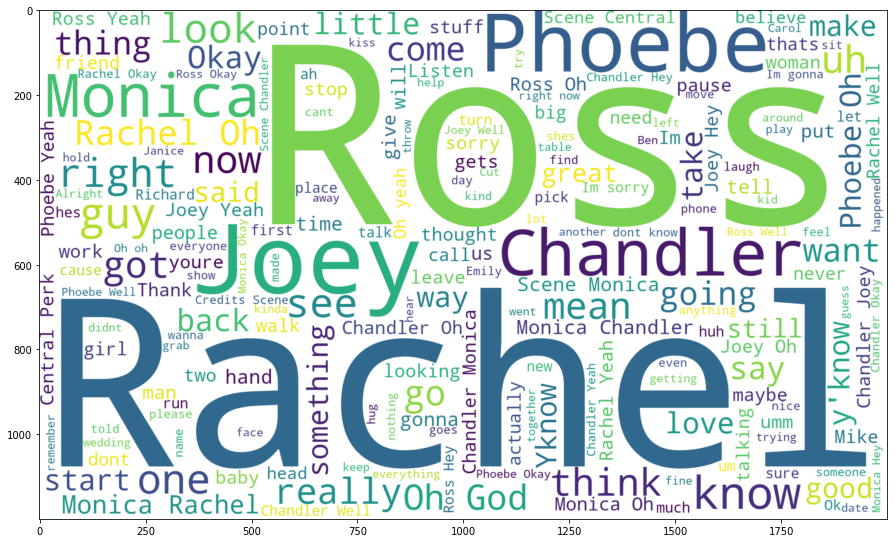

In [57]:
transcript_words  = dataloader.get_data()
wordcloud = WordCloud(width = 2000, height = 1200,
                background_color ='white',
                min_font_size = 10).generate(transcript_words)
plt.figure(figsize = (15, 10), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("on")
plt.tight_layout(pad = 10)

In [207]:
#set the batch size  , 
BATCH_SIZE = 64
BUFFER_SIZE = 10000
input_df = input_df.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
input_df

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [208]:
# Length of the chars
vocabulary_size = dataloader.get_vocab_size()
embedding_dim = 128
rnn_units = 256

In [209]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.01)

In [210]:
#class to define model
from tensorflow.keras.models import Model

class ScriptGenerateModel(Model):
  #constructor to define the layers of the model
  #layer1 embedding layer
  #layer2 GRU layer
  #layer3 , layer4, layer5 dense layer 
  def __init__(self) -> None:
      super(ScriptGenerateModel, self).__init__()
      self._layer1 = Embedding(vocabulary_size, embedding_dim,
                batch_input_shape=[BATCH_SIZE, None])
      self._layer2 = GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform')
      self._layer3 = Dense(vocabulary_size)
      self._layer4 = Dense(vocabulary_size)
      self._layer5 = Dense(vocabulary_size)

  def call(self, inputs):
    x = self._layer1(inputs)
    x = self._layer2(x)
    x = self._layer3(x)
    x = self._layer4(x)
    x = self._layer5(x)
    return x
  
#loss function of the model  
def calculate_loss(target, log):
  return tf.keras.losses.sparse_categorical_crossentropy(target, log, from_logits=True)

#initialise and build the model
model = ScriptGenerateModel()
model.compile(loss=calculate_loss,
              optimizer=optimiser,
              metrics=["accuracy"])
model.build((64, None))
model.summary()

Model: "script_generate_model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    multiple                  12032     
                                                                 
 gru_40 (GRU)                multiple                  296448    
                                                                 
 dense_56 (Dense)            multiple                  24158     
                                                                 
 dense_57 (Dense)            multiple                  8930      
                                                                 
 dense_58 (Dense)            multiple                  8930      
                                                                 
Total params: 350,498
Trainable params: 350,498
Non-trainable params: 0
_________________________________________________________________


In [211]:
for sample_input, sample_target in input_df.take(1):
    sample_batch_predict = model(sample_input)

    print(sample_batch_predict.shape, "# (batch_size, sequence_length, vocabulary_size)")

(64, 100, 94) # (batch_size, sequence_length, vocabulary_size)


In [212]:
# We are creating a chechpoint to store the weights 
ck_dir = './training_checkpoints'

ck_prefix = os.path.join(ck, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=ck_prefix,
    save_weights_only=True)

In [198]:
#train the model
history = model.fit(input_df, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
757/757 [==============================] - 16s 17ms/step - loss: 1.5793 - accuracy: 0.5459
Epoch 2/100
757/757 [==============================] - 14s 17ms/step - loss: 1.3164 - accuracy: 0.6060
Epoch 3/100
757/757 [==============================] - 14s 17ms/step - loss: 1.3000 - accuracy: 0.6100
Epoch 4/100
757/757 [==============================] - 14s 17ms/step - loss: 1.3084 - accuracy: 0.6077
Epoch 5/100
757/757 [==============================] - 14s 17ms/step - loss: 5.2833 - accuracy: 0.4921
Epoch 6/100
757/757 [==============================] - 14s 17ms/step - loss: 2.2839 - accuracy: 0.3680
Epoch 7/100
757/757 [==============================] - 14s 17ms/step - loss: 2.2067 - accuracy: 0.3840
Epoch 8/100
757/757 [==============================] - 14s 17ms/step - loss: 2.1816 - accuracy: 0.3893
Epoch 9/100
757/757 [==============================] - 14s 17ms/step - loss: 2.2019 - accuracy: 0.3847
Epoch 10/100
757/757 [==============================] - 13s 16ms/step - l

In [214]:
#Taking the weight of the previous model with batch size =1 
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_4'

In [215]:
#re intialise model with batchsize 1 for text generation
BATCH_SIZE = 1
model = ScriptGenerateModel()
model.compile(loss=calculate_loss,
              optimizer=optimiser,
              metrics=["accuracy"])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [216]:
model.summary()

Model: "script_generate_model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    multiple                  12032     
                                                                 
 gru_41 (GRU)                multiple                  296448    
                                                                 
 dense_59 (Dense)            multiple                  24158     
                                                                 
 dense_60 (Dense)            multiple                  8930      
                                                                 
 dense_61 (Dense)            multiple                  8930      
                                                                 
Total params: 350,498
Trainable params: 350,498
Non-trainable params: 0
_________________________________________________________________


In [217]:
#class to generate the transcript
class TranscriptGenerator():
  #constructor to initialise all values
  def __init__(self, num_characters: str, start: str, temperature: float = 1.0) -> None:
      self._num_characters = num_characters
      self._input_eval = self._create_vector(start)
      self._temperature = temperature
      self._start = start

  #create input vector
  def _create_vector(self, start: str):
      input = [dataloader.character_to_index[s] for s in start]
      return tf.expand_dims(input, 0)
  
  #function for text prediction
  def predict(self, model):
    # reset model states
    model.reset_states()
    output = list()

    for i in range(self._num_characters):
      predictions = tf.squeeze(model(self._input_eval), 0) / self._temperature
      ids = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
      self._input_eval = tf.expand_dims([ids], 0)
      output.append(dataloader.index_to_character[ids])
    
    return (self._start + ''.join(output))

transcript_generator = TranscriptGenerator(5000, u"Ross: ")
print(transcript_generator.predict(model))

Ross: Your sceneve take can play my anevine talk to The Piertailled it? Let me realise Ive been down that woman lag point with her rouse looking down on the broudder, right. 
Charlie how on my own ebwis how really? Oh hey. 
Ross: Tomorrow that was down cant) Thank you! I don't have achel said, tots have to ready to the plane.
Monica: Huh, u g?
Ross: (flarts finger) Theres an!
Ross: Well eater got is out. Monica startasa) He mays the window! You goodn's show his hand.
Ross: Look, are you. (pause) Okay leave... Gave yomaning hundred dirrs. The exndt , were walking up with an lady.
Rachel: Youve we are seenicul just let leave!! Who even that's right how mean! The thing to a baad?
Chandler: OH GOTD!! Well you have to restarically: Oh, we was like amay.
Llwar: (to Exits.) Um, thans never moving  now.
ROVY Green: Look How we dont feel up with scappoye an iceding) She's gonna hears!
Rachel: Ummm, Okay, I don't know.
[Scene: Tencienal! Who are, utle was freakittlow big here to - that's a boirf